# Mismatch Compression Simulation
## Effect of Impedance

### Overview
In this notebook we'll illustrate the frequency-domain distortions caused by gain compression, a source of confounding distortions in differentially recorded local field potentials (dLFP)

In dLFP, gain compression can occur if the impedances of the recording electrodes are *mismatched*.

This work is a part of a publication (submitted, [preprint]()).

### Code/Model setup

In [4]:
%reset -f
import DBSpace as dbo
import DBSpace.dLFP.diff_model as sim

import numpy as np
import allantools
from allantools.noise import pink as f_noise
import matplotlib.pyplot as plt

import scipy.signal as sig
from scipy.ndimage.filters import gaussian_filter1d

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [15, 5]

import pdb
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
import scipy.stats as stats

#plt.close('all')

import seaborn as sns
sns.set_context("paper")

sns.set(font_scale=2)
sns.set_style("ticks")
sns.set_style("white")
plt.rcParams['image.cmap'] = 'jet'

### The Differential Amplifier
The core of the dLFP recording channel, the differential amplifier simulator does a simple job: simulate the differential recording channel.

In [5]:
diff_run = sim.sim_diff(Ad=200,wform='moresine4',clock=True,stim_v=4)

### The Signal Amplifier
This is where we start dealing with the limitations of amplifiers, specifically *gain compression*.

When an amplifier is designed, it's designed to accept a range of input signals and then multiply, or *gain*, that signal up by some fixed gain factor.
Unfortunately, when we send in an input signal that's outside of the design range, we get some bad behavior: we can't output the amplitude we need to based on the fixed gain factor.
This "compresses" our output signal and gives us a smaller signal than we needed.
That's where the core of the problem is.

Let's set up our signal amplifier and attach it to our differential amplifier.
We'll set the amplifier's behavior using the $tanh(x)$ model, which is a more realistic model than the linear and piecewise linear models.
Noise, signal amp gain and pre amp gain will be fixed at trivial values.

*If you want to accentuate the effects of gain compression for illustrative purposes, or even fitting to other devices, the pre_amp_gain is where you can do it. Try setting it at 10 and see the difference that even small impedance mismatches make!*

In [6]:
amp_run = sim.sim_amp(diff_run,family='tanh',noise=1e-6,sig_amp_gain=1,pre_amp_gain=1)

### Run Simulator

Now that we've set up both our differential amplifier (diff_run) and our signal amplifier (amp_run) we can proceed with our simulation.
We'll simulate with the two recording electrode impedances as arguments.

/home/virati/Dropbox/projects/Research/MDD-DBS/Ephys/DBSpace/dLFP/diff_model.py:463: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(self.T+diff_obj.tlims[0],self.F,10*np.log10(SGdiff),rasterized=True)
/home/virati/Dropbox/projects/Research/MDD-DBS/Ephys/DBSpace/dLFP/diff_model.py:472: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(self.T+diff_obj.tlims[0],self.F,10*np.log10(SGout),rasterized=True)


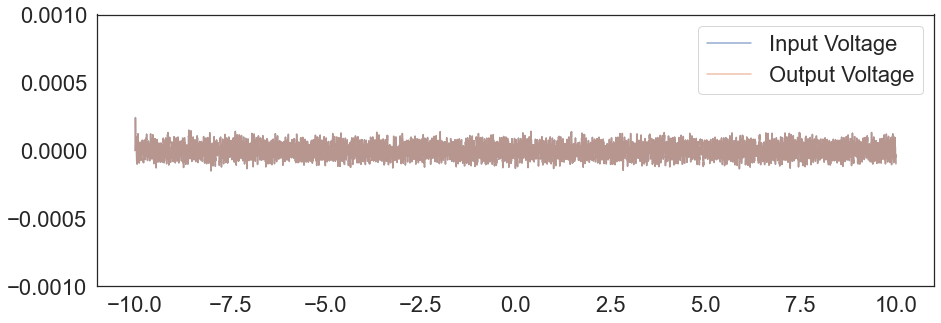

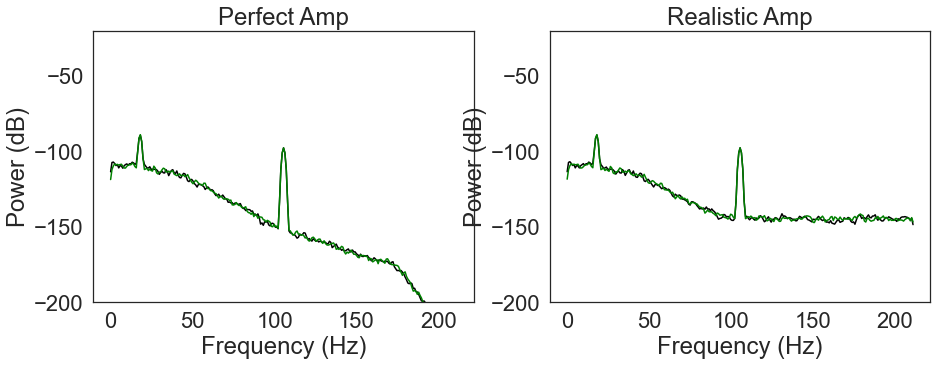

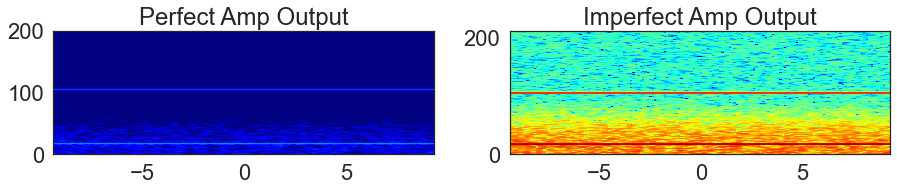

In [10]:
def sim_run(Z1=1100,Z3=1100):
    amp_run.simulate(Z1,Z3)
    amp_run.plot_time_dom()
    amp_run.plot_freq_dom()
    amp_run.plot_tf_dom()

widg = interactive(sim_run,Z1=widgets.IntSlider(min=800, max=1600, step=50, value=1000),Z3=widgets.IntSlider(min=800, max=1600, step=50, value=1000))
display(widg)

Key things to notice here between the perfect amp and the realistic amp when the stim is ON (green):
* We see major differences in how the PSD "falls off" after about 90Hz. (Slope flattening)
* We see the emergence of new peaks at 32Hz, 90-ishHz, 160Hz, etc. (Intermodulation Harmonics)

These two features are almost defining of gain compression.

## Effect of stimulation frequency
We can observe the effect that our stimulation frequency has on the mismatch compression distortions.

/home/virati/Dropbox/projects/Research/MDD-DBS/Ephys/DBSpace/dLFP/diff_model.py:463: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(self.T+diff_obj.tlims[0],self.F,10*np.log10(SGdiff),rasterized=True)
/home/virati/Dropbox/projects/Research/MDD-DBS/Ephys/DBSpace/dLFP/diff_model.py:472: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(self.T+diff_obj.tlims[0],self.F,10*np.log10(SGout),rasterized=True)


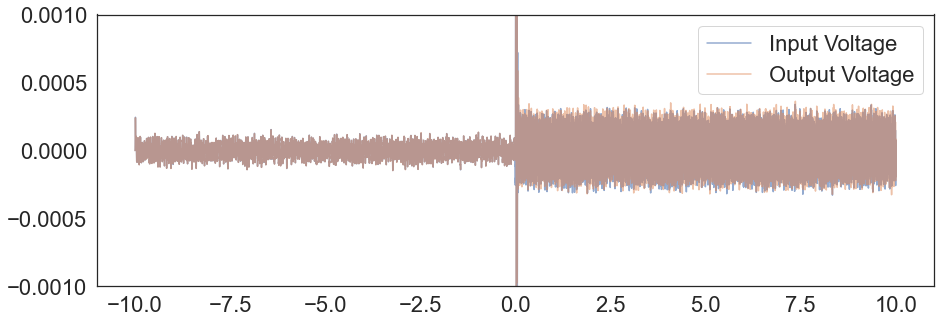

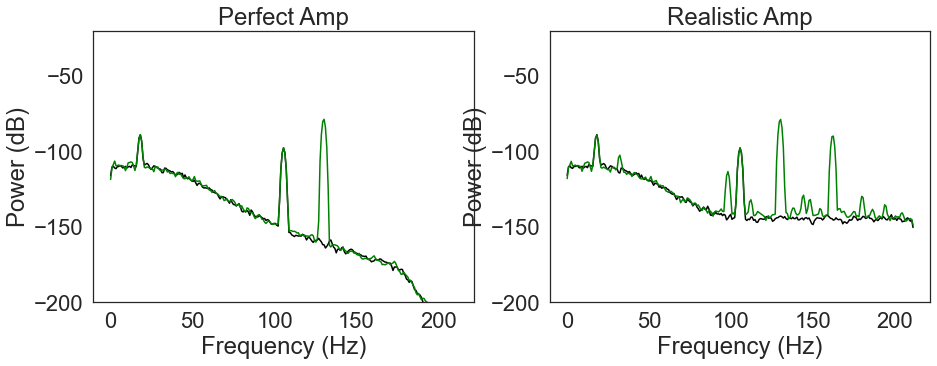

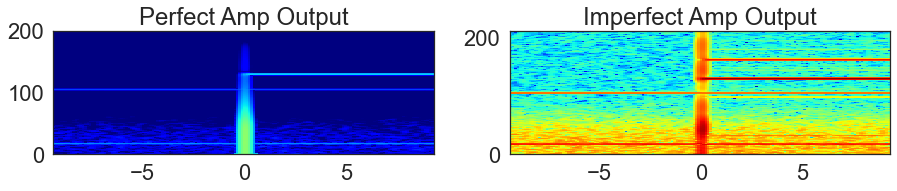

In [8]:
def sim_freq(Z1=1100,Z3=1200,freq=130):
    freq_run = sim.sim_diff(Ad=200,wform='moresine4',clock=True,stim_v=4,stim_freq=freq)
    amp_run = sim.sim_amp(freq_run,family='tanh',noise=1e-6,sig_amp_gain=1,pre_amp_gain=1)


    amp_run.simulate(Z1,Z3)
    amp_run.plot_time_dom()
    amp_run.plot_freq_dom()
    amp_run.plot_tf_dom()

interactive(sim_freq,Z1=widgets.IntSlider(min=800, max=1600, step=50, value=1000),Z3=widgets.IntSlider(min=800, max=1600, step=50, value=1200),freq=(70,180,10))